In [4]:
from datetime import datetime as dt

import numpy as np

import pandas as pd
pd.options.display.max_rows = 999
pd.options.display.max_columns = 999

import matplotlib.pyplot as plt
plt.style.use('seaborn-white')
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.serif'] = 'Arial'
plt.rcParams['font.size'] = 20
plt.rcParams['axes.labelweight'] = 'bold'

import plotly.offline as opy
import plotly.graph_objs as go
opy.init_notebook_mode()

import utils
from biopharma_scheduling.utils import hypervolume
from biopharma_scheduling.single_site.deterministic import DetSingleSiteSimple, DetSingleSiteMultiSuite

from IPython.core.display import display, HTML

In [5]:
%load_ext autoreload
%autoreload 2

In [6]:
# How the input data is stored doesn't matter as long as Pandas DataFrames are used in the end
start_date = '2016-12-01'
kg_demand = pd.read_csv('data/deterministic_single_site_simple/kg_demand.csv', index_col='date')
kg_inventory_target = pd.read_csv('data/deterministic_single_site_simple/kg_inventory_target.csv', index_col='date')
product_data = pd.read_csv('data/deterministic_single_site_simple/product_data.csv')
changeover_days = pd.read_csv('data/deterministic_single_site_simple/changeover_days.csv')
    
# Product colors to display in the Gantt charts
colors = {
    'A': 'rgb(146, 208, 80)', 
    'B': 'rgb(179, 129, 217)', 
    'C': 'rgb(196, 189, 151)', 
    'D': 'rgb(255, 0, 0)'
}

In [7]:
pd.options.display.max_rows = 999
display(HTML('<h4/>Product data'))
product_data.index = product_data['product']
display(product_data.drop('product', axis=1).transpose())

display(HTML('<h4/>Sequence-dependent changeovers [days]'))
changeover_days.index = changeover_days['product']
display(changeover_days.drop('product', axis=1))

display(HTML('<h4/>Product demand (inventory target) [kg]'))
kg_demand.transpose()

product                                A      B      C      D
inoculation_days                    20.0   15.0   20.0   26.0
seed_days                           11.0    7.0   11.0    9.0
production_days                     14.0   14.0   14.0   14.0
usp_days                            45.0   36.0   45.0   49.0
dsp_days                             7.0   11.0    7.0    7.0
approval_days                       90.0   90.0   90.0   90.0
shelf_life_days                    730.0  730.0  730.0  730.0
kg_yield_per_batch                   3.1    6.2    4.9    5.5
kg_storage_limits                  250.0  250.0  250.0  250.0
kg_opening_stock                    18.6    0.0   19.6   32.0
min_batches_per_campaign             2.0    2.0    2.0    2.0
max_batches_per_campaign            50.0   50.0   50.0   30.0
batches_multiples_of_per_campaign    1.0    1.0    1.0    3.0
production_cost_per_kg               1.0    1.0    1.0    1.0
sell_price_per_kg                    1.0    1.0    1.0    1.0
inventory_penalty_per_kg             1.0    1.0    1.0    1.0
backlog_penalty_per_kg               1.0    1.0    1.0    1.0
storage_cost_per_kg                  1.0    1.0    1.0    1.0
waste_cost_per_kg                    1.0    1.0    1.0    1.0

A   B   C   D
product                
A         0  10  16  20
B        16   0  16  20
C        16  10   0  20
D        18  10  18   0

date  2017-01-01  2017-02-01  2017-03-01  2017-04-01  2017-05-01  2017-06-01  \
A            0.0         0.0         3.1         0.0         0.0         3.1   
B            0.0         0.0         0.0         0.0         0.0         0.0   
C            0.0         0.0         0.0         0.0         0.0         0.0   
D            0.0         5.5         5.5         0.0         5.5         5.5   

date  2017-07-01  2017-08-01  2017-09-01  2017-10-01  2017-11-01  2017-12-01  \
A            0.0         3.1         3.1         3.1         0.0         6.2   
B            0.0         0.0         0.0         0.0         0.0         0.0   
C            4.9         4.9         0.0         0.0         0.0         9.8   
D            5.5         5.5         5.5         0.0        11.0         5.5   

date  2018-01-01  2018-02-01  2018-03-01  2018-04-01  2018-05-01  2018-06-01  \
A            6.2         3.1         6.2         0.0         3.1         9.3   
B            0.0         0.0         0.0         0.0         0.0         0.0   
C            4.9         0.0         4.9         0.0         0.0         4.9   
D            0.0         5.5         5.5        11.0         5.5         5.5   

date  2018-07-01  2018-08-01  2018-09-01  2018-10-01  2018-11-01  2018-12-01  \
A            0.0         6.2         6.2         0.0         6.2         9.3   
B            0.0         0.0         0.0         0.0         6.2         0.0   
C            9.8         0.0         0.0         0.0         4.9         4.9   
D            0.0         5.5         5.5         5.5        11.0         5.5   

date  2019-01-01  2019-02-01  2019-03-01  2019-04-01  2019-05-01  2019-06-01  \
A            0.0         9.3         6.2         3.1         6.2         3.1   
B            0.0         0.0         0.0         0.0         6.2         0.0   
C            0.0         9.8         0.0         0.0         4.9         9.8   
D            0.0        11.0         0.0        11.0         5.5         5.5   

date  2019-07-01  2019-08-01  2019-09-01  2019-10-01  2019-11-01  2019-12-01  
A            0.0         9.3         6.2         9.3         6.2         0.0  
B            0.0         0.0         0.0         0.0         0.0         6.2  
C            9.8         0.0         4.9         9.8         4.9         0.0  
D            0.0        11.0        11.0         0.0         5.5         5.5

In [8]:
objectives = {
    'total_kg_throughput': 1 # max
}

constraints = {
    'total_kg_backlog': [-1, 0], # <= 0
    'total_kg_waste': [-1, 0] # <= 0
}

ga_params = {
    'num_runs': 50,
    'num_gens': 1000,
    'popsize': 1000,
    'starting_length': 1,
    'p_xo': 0.108198,
    'p_product_mut': 0.041373,
    'p_plus_batch_mut': 0.608130,
    'p_minus_batch_mut': 0.765819,
    'p_gene_swap': 0.471346,
}

model = DetSingleSiteSimple(**ga_params, random_state=7, num_threads=-1, verbose=True).fit(
    start_date,
    objectives,
    kg_demand,
    product_data,
    changeover_days,
    kg_inventory_target,
    constraints
)

model.schedules[0].objectives.transpose()

Done: 100%|██████████| 50000/50000 [11:22<00:00, 73.27it/s]


value
total_backlog_penalty          0.0
total_cost                  1099.7
total_inventory_penalty      469.3
total_kg_backlog               0.0
total_kg_inventory_deficit   469.3
total_kg_supply              449.8
total_kg_throughput          630.4
total_kg_waste                 0.0
total_production_cost        630.4
total_profit                -649.9
total_revenue                449.8
total_storage_cost             0.0
total_waste_cost               0.0

In [9]:
objectives = {
    'total_kg_inventory_deficit': -1 # max
}

constraints = {
    'total_kg_backlog': [-1, 0], # <= 0
    'total_kg_waste': [-1, 0] # <= 0
}

ga_params = {
    'num_runs': 50,
    'num_gens': 1000,
    'popsize': 1000,
    'starting_length': 1,
    'p_xo': 0.108198,
    'p_product_mut': 0.041373,
    'p_plus_batch_mut': 0.608130,
    'p_minus_batch_mut': 0.765819,
    'p_gene_swap': 0.471346,
}

model = DetSingleSiteSimple(**ga_params, random_state=7, num_threads=-1, verbose=True).fit(
    start_date,
    objectives,
    kg_demand,
    product_data,
    changeover_days,
    kg_inventory_target,
    constraints
)

model.schedules[0].objectives.transpose()

Done: 100%|██████████| 50000/50000 [11:19<00:00, 73.56it/s]


value
total_backlog_penalty         0.0
total_cost                  697.9
total_inventory_penalty     184.8
total_kg_backlog              0.0
total_kg_inventory_deficit  184.8
total_kg_supply             449.8
total_kg_throughput         513.1
total_kg_waste                0.0
total_production_cost       513.1
total_profit               -248.1
total_revenue               449.8
total_storage_cost            0.0
total_waste_cost              0.0

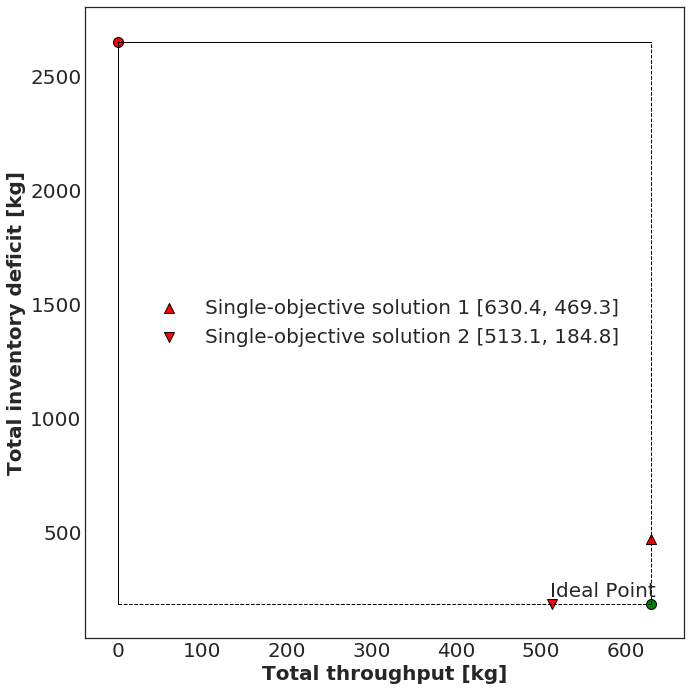

In [10]:
plt.rcParams['font.size'] = 20

# Reference point, worst possible values, for calculating the hypervolume
ref_point = [0, kg_inventory_target.sum().sum()]

# Ideal point is based on the best objective values achieved with single-objective GAs (model1 and model2) 
ideal_point = [630.4, 184.8]

fig = utils.plot_2D_pareto_front(
    [ref_point[0], ideal_point[0]], 
    [ideal_point[1], ref_point[1]], 
    'Total throughput [kg]',
    'Total inventory deficit [kg]',
    figsize=(10, 10),
    ref_point=ref_point,
    ideal_point=ideal_point,
    markercolor='white',
    edgecolor='black',
    markeralpha=0
)

axes = plt.gca()

soga_solution1 = [630.4, 469.3]
soga_solution2 = [513.1, 184.8]

axes.scatter(
    soga_solution1[0],
    soga_solution1[1],
    marker='^',
    edgecolor='black',
    s=100,
    color='red',
    label='Single-objective solution 1 {}'.format(soga_solution1) 
)

axes.scatter(
    soga_solution2[0],
    soga_solution2[1],
    marker='v',
    edgecolor='black',
    s=100,
    color='red',
    label='Single-objective solution 2 {}'.format(soga_solution2)
)

# Mark ideal point
plt.text(ideal_point[0] - 120, ideal_point[1] + 30, 'Ideal Point')

plt.tight_layout()
plt.legend(loc='best')
plt.show()

In [45]:
# ga_params = {
#     'num_runs': 50,
#     'num_gens': 1000,
#     'popsize': 600,
#     'starting_length': 1,
#     'p_xo': 0.108198,
#     'p_product_mut': 0.041373,
#     'p_plus_batch_mut': 0.608130,
#     'p_minus_batch_mut': 0.765819,
#     'p_gene_swap': 0.471346,
# }

# ga_params = {
#     'num_runs': 50,
#     'num_gens': 1000,
#     'popsize': 600,
#     'starting_length': 1,
#     'p_xo': 0.108198,
#     'p_product_mut': 0.0,
#     'p_plus_batch_mut': 0.608130,
#     'p_minus_batch_mut': 0.765819,
#     'p_gene_swap': 0.471346,
# }

ga_params = {
    'num_runs': 50,
    'num_gens': 1000,
    'popsize': 600,
    'starting_length': 1,
    'p_xo': 0.5,
    'p_product_mut': 0.5,
    'p_plus_batch_mut': 0.5,
    'p_minus_batch_mut': 0.5,
    'p_gene_swap': 0.0,
}

objectives = {
    'total_kg_throughput': 1,
    'total_kg_inventory_deficit': -1 # maximisation, -1 for minimisation
}

constraints = {
    'total_kg_backlog': [-1, 0], # total_kg_backlog <= 0
    'total_kg_waste': [-1, 0] # total_kg_waste <= 0
}

model = DetSingleSiteSimple(**ga_params, random_state=7, num_threads=-1, verbose=True, save_history=True).fit(
    start_date,
    objectives,
    kg_demand,
    product_data,
    changeover_days,
    kg_inventory_target,
    constraints
);

Done: 100%|██████████| 50000/50000 [18:54<00:00, 44.08it/s]


In [46]:
solution_x = min(model.schedules, key=lambda s: s.objectives.total_kg_throughput[0])
solution_y = max(model.schedules, key=lambda s: s.objectives.total_kg_throughput[0])

display(solution_x.objectives.transpose())

df = solution_x.campaigns
df['Duration'] = df['Last Batch'] - df['Start']
display(df.describe())

# solution_x.campaigns_gantt(colors)
# solution_x.tasks_gantt(colors)

display(solution_y.objectives.transpose())

df = solution_y.campaigns
df['Duration'] = df['Last Batch'] - df['Start']
display(df.describe())

# solution_y.campaigns_gantt(colors)
# solution_y.tasks_gantt(colors)

value
total_backlog_penalty         0.0
total_cost                  735.8
total_inventory_penalty     275.2
total_kg_backlog              0.0
total_kg_inventory_deficit  275.2
total_kg_supply             449.8
total_kg_throughput         460.6
total_kg_waste                0.0
total_production_cost       460.6
total_profit               -286.0
total_revenue               449.8
total_storage_cost            0.0
total_waste_cost              0.0

Batches         Kg                 Duration
count  12.00000  12.000000                       12
mean    9.00000  38.383333        109 days 04:00:00
std     5.04525  19.501694  35 days 09:59:51.529400
min     2.00000  12.400000         58 days 00:00:00
25%     5.50000  25.825000         86 days 12:00:00
50%     9.00000  35.100000        110 days 00:00:00
75%    12.75000  49.525000        137 days 06:00:00
max    16.00000  73.500000        157 days 00:00:00

value
total_backlog_penalty          0.0
total_cost                  1032.4
total_inventory_penalty      411.7
total_kg_backlog               0.0
total_kg_inventory_deficit   411.7
total_kg_supply              449.8
total_kg_throughput          620.7
total_kg_waste                 0.0
total_production_cost        620.7
total_profit                -582.6
total_revenue                449.8
total_storage_cost             0.0
total_waste_cost               0.0

Batches          Kg                 Duration
count   8.000000    8.000000                        8
mean   16.375000   77.587500        160 days 21:00:00
std    13.255053   57.093293  94 days 00:22:50.401099
min     2.000000   12.400000         58 days 00:00:00
25%     4.250000   21.475000         74 days 12:00:00
50%    16.500000   86.550000        162 days 12:00:00
75%    23.250000  116.075000        211 days 18:00:00
max    38.000000  165.000000        311 days 00:00:00

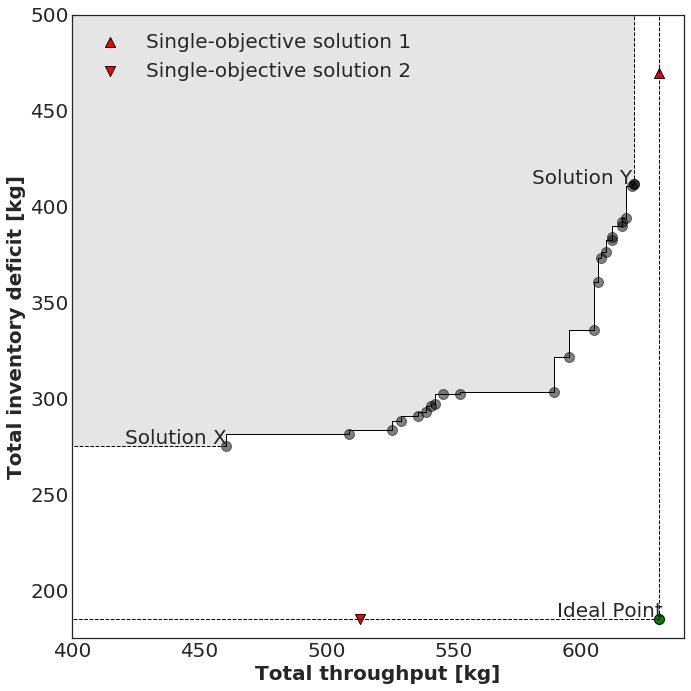

In [49]:
plt.rcParams['font.size'] = 20

objective_x = 'total_kg_throughput'
objective_y = 'total_kg_inventory_deficit'

# Extract the values for each objective
x = [
    s.objectives[objective_x].values[0] for s in model.schedules
    if s.objectives['total_kg_waste'].values[0] + s.objectives['total_kg_backlog'].values[0] <= 0    
]
y = [
    s.objectives[objective_y].values[0] for s in model.schedules
    if s.objectives['total_kg_waste'].values[0] + s.objectives['total_kg_backlog'].values[0] <= 0
]

fig = utils.plot_2D_pareto_front(
    x, #[ref_point[0], ideal_point[0]], 
    y, #[ideal_point[1], ref_point[1]], 
    'Total throughput [kg]',
    'Total inventory deficit [kg]',
    figsize=(10, 10),
    ref_point=ref_point,
    ideal_point=ideal_point,
    fillcolor='black',
    fillalpha=0.1,
)

# Calculate raw hypervolume value
raw_hv = hypervolume(
    model.schedules,
    objectives,
    ref_point={
        objective_x: ref_point[0],
        objective_y: ref_point[1]
    }
)

# Calculate normalised hypervolume value (0.0 - 1.0)
norm_hv = hypervolume(
    model.schedules,
    objectives,
    ref_point={
        objective_x: ref_point[0],
        objective_y: ref_point[1]
    },
    ideal_point={
        objective_x: ideal_point[0],
        objective_y: ideal_point[1]        
    }
)

axes = plt.gca()
axes.set_xlim([400, 10 + max(max(x), ideal_point[0])])
axes.set_ylim([min(min(y), ideal_point[1]) - 10, 500])

axes.scatter(
    soga_solution1[0],
    soga_solution1[1],
    marker='^',
    edgecolor='black',
    s=100,
    color='red',
    label='Single-objective solution 1'
)

axes.scatter(
    soga_solution2[0],
    soga_solution2[1],
    marker='v',
    edgecolor='black',
    s=100,
    color='red',
    label='Single-objective solution 2'
)

# Mark the boundary solutions of the Pareto fron
plt.text(np.min(x) - 40, np.min(y) + 1, 'Solution X')
plt.text(np.max(x) - 40, np.max(y), 'Solution Y')

# Mark ideal point
# plt.text(ref_point[0] - 30, ref_point[1] + 20, 'Ref. Point')

# Mark ideal point
plt.text(ideal_point[0] - 40, ideal_point[1] + 1, 'Ideal Point')

plt.tight_layout()
plt.legend(loc='best')
plt.show()

utils.display(utils.HTML('<h4/>Hypervolume: %.1f (%.4f)' % (raw_hv, norm_hv)))

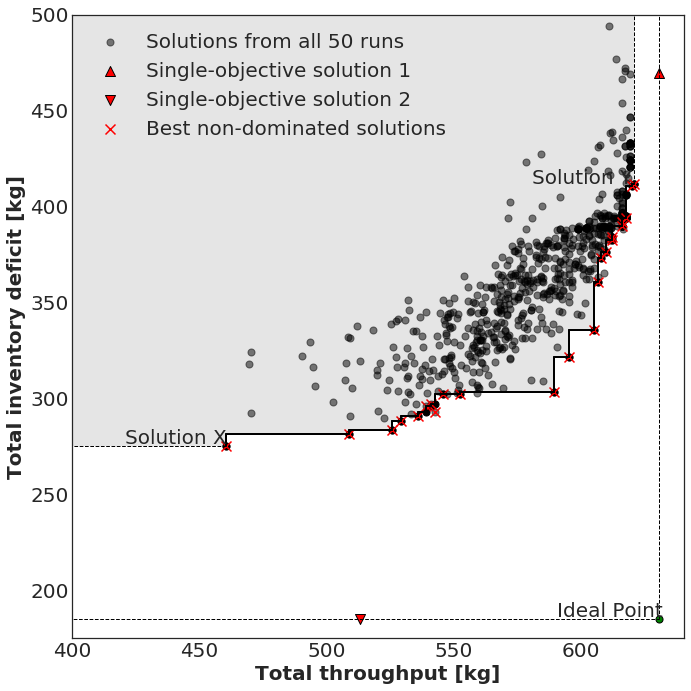

In [50]:
plt.rcParams['font.size'] = 20

x_history = [
    s.objectives[objective_x].values[0] for schedules in model.history for s in schedules 
    if s.objectives['total_kg_waste'].values[0] + s.objectives['total_kg_backlog'].values[0] <= 0
]
y_history = [
    s.objectives[objective_y].values[0] for schedules in model.history for s in schedules
    if s.objectives['total_kg_waste'].values[0] + s.objectives['total_kg_backlog'].values[0] <= 0
]

fig = utils.plot_2D_pareto_front(
    x, 
    y, 
    'Total throughput [kg]',
    'Total inventory deficit [kg]',
    figsize=(10, 10),
    ref_point=ref_point,
    ideal_point=ideal_point,
    markeralpha=1,
    fillcolor='black',
    fillalpha=0.1,
    markersize=50,
    linewidth=2,
)

axes = plt.gca()
axes.set_xlim([400, 10 + max(max(x), ideal_point[0])])
axes.set_ylim([min(min(y), ideal_point[1]) - 10, 500])

axes.scatter(
    x_history,
    y_history,
    marker='o',
    alpha=0.5,
    edgecolor='black',
    s=50,
    color='black',
    label='Solutions from all 50 runs'
)

axes.scatter(
    soga_solution1[0],
    soga_solution1[1],
    marker='^',
    edgecolor='black',
    s=100,
    color='red',
    label='Single-objective solution 1'
)

axes.scatter(
    soga_solution2[0],
    soga_solution2[1],
    marker='v',
    edgecolor='black',
    s=100,
    color='red',
    label='Single-objective solution 2'
)

axes.scatter(
    x,
    y,
    marker='x',
    edgecolor='black',
    s=100,
    color='red',
    label='Best non-dominated solutions'
)

# Mark the boundary solutions of the Pareto fron
plt.text(np.min(x) - 40, np.min(y) + 1, 'Solution X')
plt.text(np.max(x) - 40, np.max(y), 'Solution Y')

# Mark ideal point
plt.text(ideal_point[0] - 40, ideal_point[1] + 1, 'Ideal Point')

plt.tight_layout()
plt.legend(loc='best')
plt.show()

hypervolumes = [
    hypervolume(
        schedules,
        objectives,
        ref_point={
            objective_x: ref_point[0],
            objective_y: ref_point[1]
        },
        ideal_point={
            objective_x: ideal_point[0],
            objective_y: ideal_point[1]        
        }
    ) for schedules in model.history
]

utils.display(utils.HTML('<h4/>No. solutions: %d' % len(x)))
utils.display(utils.HTML('<h4/>Max Hypervolume: %.1f (%.4f)' % (raw_hv, norm_hv)))
utils.display(utils.HTML('<h4/>Mean Hypervolume: %.4f (%.4f)' % (np.mean(hypervolumes), np.std(hypervolumes))))

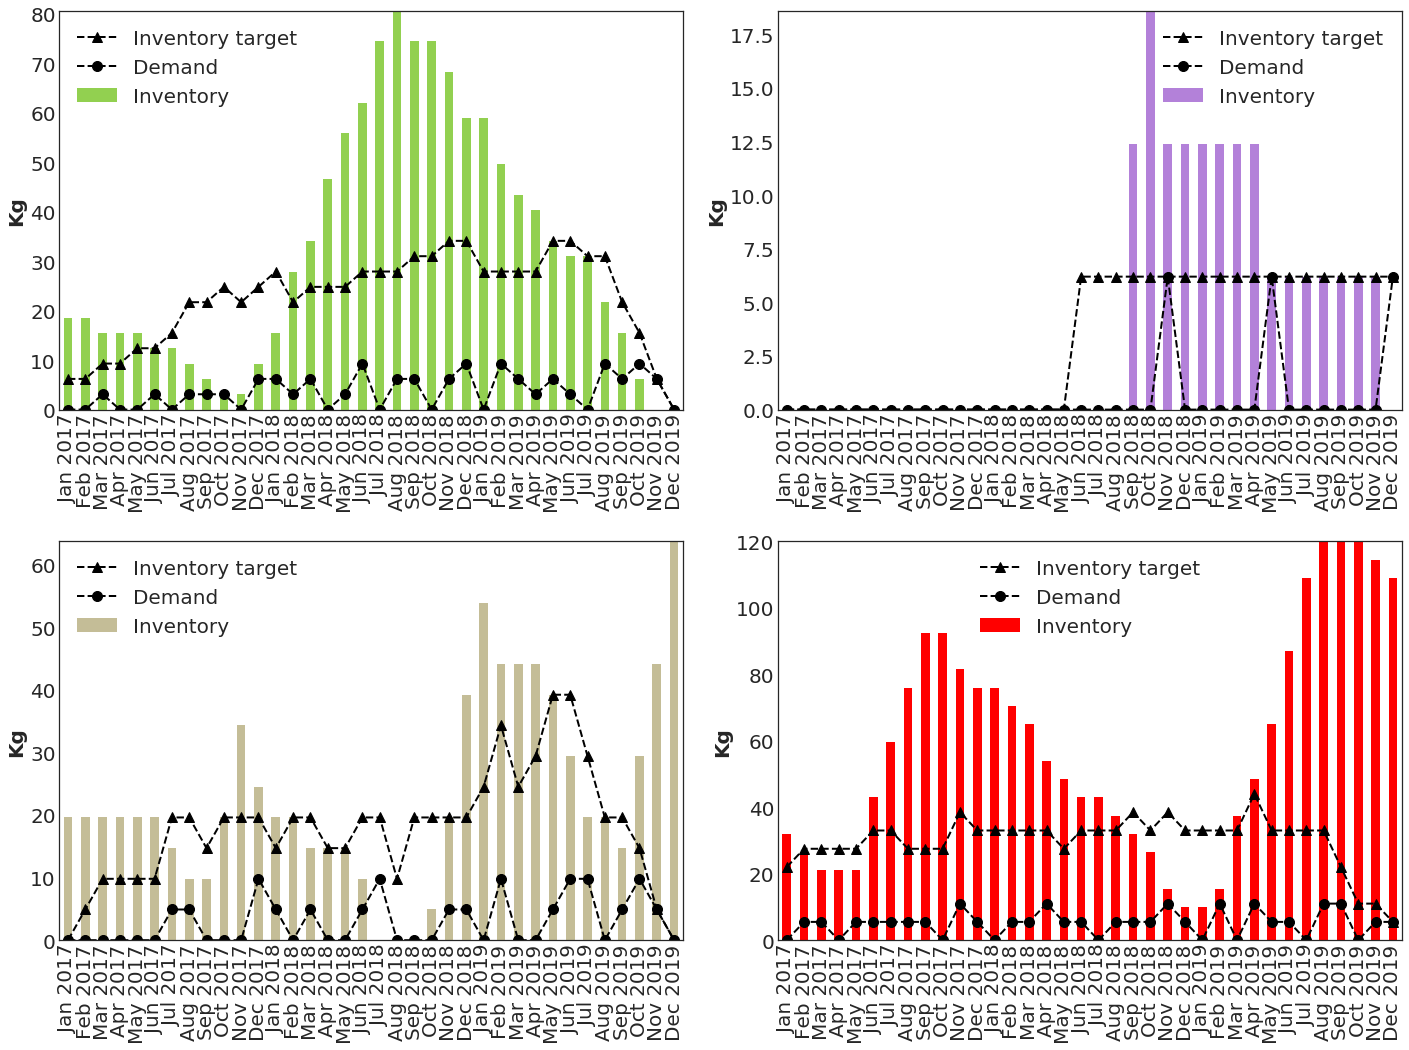

In [40]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(20, 15))
xticks = [dt.strftime(d, '%b %Y') for d in pd.to_datetime(kg_demand.index)]
plt_colors = {
    'A': (146, 208, 80), 
    'B': (179, 129, 217), 
    'C': (196, 189, 151), 
    'D': (255, 0, 0)
}

solution = solution_y

for i in range(2):
    for j in range(2):
        p = kg_demand.columns[i * 2 + j]
        
        solution.kg_inventory[[p]].plot(
            ax=ax[i][j],
            kind='bar', 
            color=tuple([x / 255 for x in plt_colors[p]]),
        )

        kg_inventory_target[[p]].plot(
            ax=ax[i][j],
            kind='line',
            color='black',
            linewidth=2,
            linestyle='--',
            marker='^',
            markersize=10,
        )
        
        kg_demand[[p]].plot(
            ax=ax[i][j],
            kind='line',
            color='black',
            linewidth=2,
            linestyle='--',
            marker='o',
            markersize=10,
        )

        ax[i][j].set_xticks(range(len(xticks)))
        ax[i][j].set_xticklabels(xticks, rotation='vertical')
        ax[i][j].set_ylim([0, solution_y.kg_inventory[p].max()])
        ax[i][j].legend(['Inventory target', 'Demand', 'Inventory'], loc='best')
        ax[i][j].set_xlabel('')
        ax[i][j].set_ylabel('Kg')
        
plt.tight_layout()
plt.show()

# plt.savefig('levels.png');

In [13]:
solution_x.kg_inventory.describe()

A          B          C          D
count  36.000000  36.000000  36.000000  36.000000
mean   25.402778   4.477778  26.541667  52.166667
std    15.219696   5.263194  11.196718  20.662941
min     3.100000   0.000000   9.800000  21.000000
25%    12.400000   0.000000  19.600000  32.000000
50%    24.800000   0.000000  22.050000  54.000000
75%    32.550000   7.750000  34.300000  66.375000
max    55.800000  12.400000  53.900000  98.000000

In [14]:
solution_y.kg_inventory.describe()

A          B          C           D
count  3.600000e+01  36.000000  36.000000   36.000000
mean   2.953611e+01   3.788889  25.044444   61.944444
std    2.391495e+01   5.400517  14.525258   41.188552
min    2.664535e-15   0.000000   4.900000   10.000000
25%    1.162500e+01   0.000000  14.700000   26.500000
50%    2.015000e+01   0.000000  19.600000   56.750000
75%    4.727500e+01   6.200000  30.625000   89.750000
max    7.440000e+01  18.600000  58.800000  169.500000

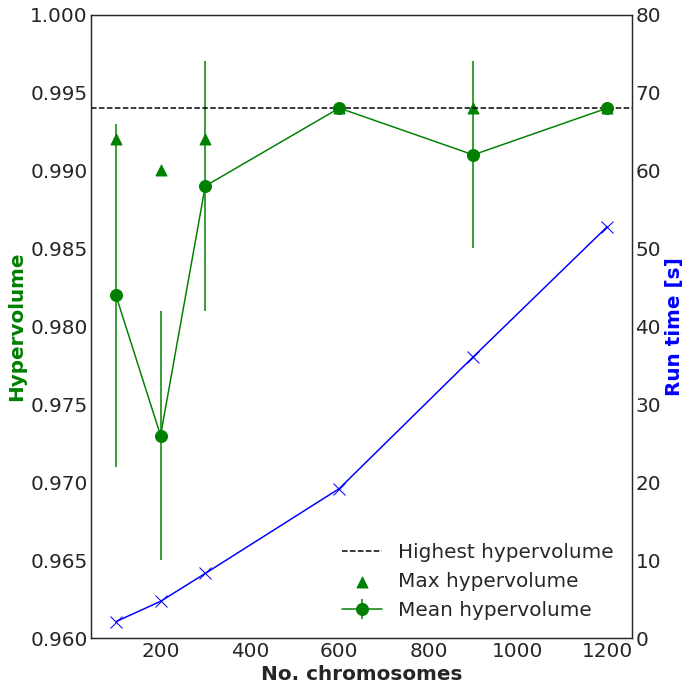

In [15]:
max_hv = [0.992, 0.990, 0.992, 0.994, 0.994, 0.994]
mean_hv = [0.982, 0.973, 0.989, 0.994, 0.991, 0.994]
std_hv = [0.011, 0.008, 0.008, 0, 0.006, 0]
time = [2.14, 4.74, 8.32, 19.20, 36.10, 52.8]
x_ticks = [100, 200, 300, 600, 900, 1200]

plt.rcParams['font.size'] = 20
fig, ax1 = plt.subplots(figsize=(10, 10))

ax1.set_xlabel('No. chromosomes')

ax1.scatter(x_ticks, max_hv, marker='^', s=120, color='green', label='Max')
ax1.errorbar(x_ticks, mean_hv, yerr=std_hv, marker='o', markersize=12, color='green', label='Mean')
ax1.set_ylabel('Hypervolume', color='green')
ax1.set_ylim([0.96, 1.0])
ax1.axhline(0.994, linestyle='--', color='black')
ax1.legend(['Highest hypervolume', 'Max hypervolume', 'Mean hypervolume'], loc='lower right')

ax2 = ax1.twinx()
ax2.plot(x_ticks, time, marker='x', markersize=12, color='blue')
ax2.set_ylabel('Run time [s]', color='b')
ax2.set_ylim([0, 80])

plt.tight_layout();

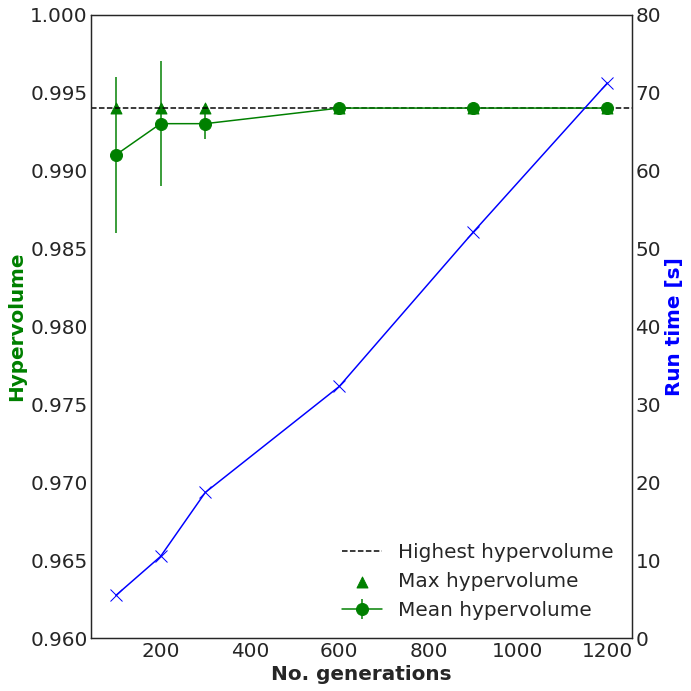

In [16]:
max_hv = [0.994, 0.994, 0.994, 0.994, 0.994, 0.994]
mean_hv = [0.991, 0.993, 0.993, 0.994, 0.994, 0.994]
std_hv = [0.005, 0.004, 0.001, 0.0, 0.0, 0.0]
time = [5.5, 10.5, 18.7, 32.3, 52.1, 71.2]
x_ticks = [100, 200, 300, 600, 900, 1200]

plt.rcParams['font.size'] = 20
fig, ax1 = plt.subplots(figsize=(10, 10))

ax1.set_xlabel('No. generations')

ax1.scatter(x_ticks, max_hv, marker='^', s=120, color='green', label='Max')
ax1.errorbar(x_ticks, mean_hv, yerr=std_hv, marker='o', markersize=12, color='green', label='Mean')
ax1.set_ylabel('Hypervolume', color='green')
ax1.set_ylim([0.96, 1.0])
ax1.axhline(0.994, linestyle='--', color='black')
ax1.legend(['Highest hypervolume', 'Max hypervolume', 'Mean hypervolume'], loc='lower right')

ax2 = ax1.twinx()
ax2.plot(x_ticks, time, marker='x', markersize=12, color='blue')
ax2.set_ylabel('Run time [s]', color='b')
ax2.set_ylim([0, 80])

plt.tight_layout();

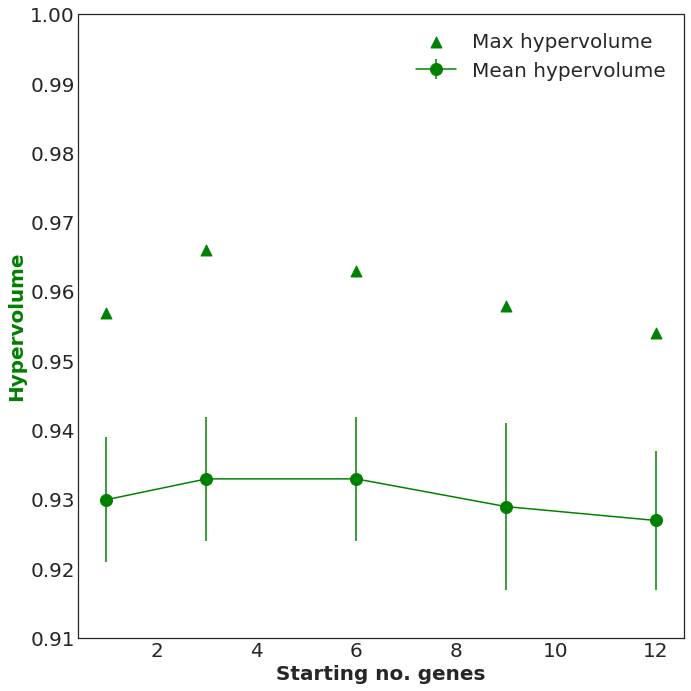

In [18]:
max_hv = [0.957, 0.966, 0.963, 0.958, 0.954]
mean_hv = [0.930, 0.933, 0.933, 0.929, 0.927]
std_hv = [0.009, 0.009, 0.009, 0.012, 0.010]
x_ticks = [1, 3, 6, 9, 12]

plt.rcParams['font.size'] = 20
fig, ax1 = plt.subplots(figsize=(10, 10))

ax1.set_xlabel('Starting no. genes')

ax1.scatter(x_ticks, max_hv, marker='^', s=120, color='green', label='Max')
ax1.errorbar(x_ticks, mean_hv, yerr=std_hv, marker='o', markersize=12, color='green', label='Mean')
ax1.set_ylabel('Hypervolume', color='green')
ax1.set_ylim([0.910, 1.0])
ax1.legend(['Max hypervolume', 'Mean hypervolume'], loc='best')

plt.tight_layout();